In [1]:
!pip install torch torchvision umap-learn scikit-learn matplotlib adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.0 MB/s eta 0:00:0000:01


### Import required libraries

In [20]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import train_test_split
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from umap import UMAP
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.backends.cudnn as cudnn
from torch.autograd import *
from torchvision.transforms.functional import resize
import torchvision
import torchvision.transforms as transforms
import random
import random
import os
import argparse
import pickle

### Setting device for training


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### calculate dataset's Mean and standard deviation

In [4]:
def calculate_dataset_stats():
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
    loader = DataLoader(train_dataset, batch_size=128, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [5]:
mean, std = calculate_dataset_stats()

100%|██████████| 170498071/170498071 [00:08<00:00, 19840787.81it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [6]:
print(f"Calculated Mean: {mean}")

Calculated Mean: tensor([0.4914, 0.4822, 0.4465])


In [7]:
print(f"Calculated Std: {std}")

Calculated Std: tensor([0.2023, 0.1994, 0.2010])


### transformation

In [8]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### balanced training set

In [9]:
def create_balanced_split(dataset, samples_per_class=4000):
    class_indices = [[] for _ in range(10)]

    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    train_indices = []
    for indices in class_indices:
        np.random.shuffle(indices)
        train_indices.extend(indices[:samples_per_class])

    # Use the remaining indices for validation
    val_indices = list(set(range(len(dataset))) - set(train_indices))

    return Subset(dataset, train_indices), Subset(dataset, val_indices)

In [10]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

Files already downloaded and verified


### Create balanced training and validation subsets


In [11]:
train_subset, val_subset = create_balanced_split(train_dataset)

### ensuring count per class in Train set

In [12]:
def count_samples_per_class(dataset):
    class_counts = {i: 0 for i in range(10)}

    for index in dataset.indices:
        label = dataset.dataset.targets[index]
        class_counts[label] += 1

    return class_counts

### Count the samples in the training subset


In [13]:
train_class_counts = count_samples_per_class(train_subset)
print("Training class counts:", train_class_counts)

Training class counts: {0: 4000, 1: 4000, 2: 4000, 3: 4000, 4: 4000, 5: 4000, 6: 4000, 7: 4000, 8: 4000, 9: 4000}


In [14]:
train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

In [15]:
test_loader = DataLoader(datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test), batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified


In [16]:
model = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 147MB/s]


### Modify the final layer to output 10 classes

In [17]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = ExponentialLR(optimizer, gamma=0.99)

### define taining

In [25]:
import torch
import random
import numpy as np

def train(model, train_loader, optimizer, criterion, epsilon=0.1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        # Decide randomly whether to use adversarial examples
        if random.random() < 0.5:  # 50% probability
            # Perturb the image
            perturbed_inputs = inputs.clone()
            for _ in range(15):  # Assuming num_pixels=15 for perturbation
                x = random.randint(0, perturbed_inputs.size(2) - 1)
                y = random.randint(0, perturbed_inputs.size(3) - 1)
                perturbed_inputs[:, :, x, y] = torch.rand_like(perturbed_inputs[:, :, x, y])
            
            # Apply FGSM
            x_ = perturbed_inputs.requires_grad_(True)
            outputs_ = model(x_)
            loss_ = criterion(outputs_, targets)
            model.zero_grad()
            loss_.backward()
            pert = epsilon * x_.grad.sign()
            adv_inputs = perturbed_inputs + pert
            inputs = adv_inputs.detach()

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100. * correct / total
    return train_loss, train_accuracy


### also for validation :)

In [28]:
def validate(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    val_loss = running_loss / len(val_loader)
    val_accuracy = 100. * correct / total
    return val_loss, val_accuracy

### Initialize lists to store per-epoch loss and accuracy --  append the metrics to their respective lists

In [27]:
eps=0.1
epsilon=0.1

In [29]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

epochs = 15

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = validate(model, val_loader, criterion)
    scheduler.step()

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch: 1, Train Loss: 1.9331, Train Acc: 29.10%, Val Loss: 1.3777, Val Acc: 54.04%
Epoch: 2, Train Loss: 1.5825, Train Acc: 40.59%, Val Loss: 1.2413, Val Acc: 58.56%
Epoch: 4, Train Loss: 1.3673, Train Acc: 49.52%, Val Loss: 1.0775, Val Acc: 65.13%
Epoch: 5, Train Loss: 1.3320, Train Acc: 50.91%, Val Loss: 1.0279, Val Acc: 66.68%
Epoch: 6, Train Loss: 1.3526, Train Acc: 50.19%, Val Loss: 1.0779, Val Acc: 65.21%
Epoch: 7, Train Loss: 1.2829, Train Acc: 52.84%, Val Loss: 1.0916, Val Acc: 65.51%
Epoch: 8, Train Loss: 1.2327, Train Acc: 55.11%, Val Loss: 0.9904, Val Acc: 68.62%
Epoch: 9, Train Loss: 1.2593, Train Acc: 53.53%, Val Loss: 1.0459, Val Acc: 66.70%
Epoch: 10, Train Loss: 1.2634, Train Acc: 53.80%, Val Loss: 1.0897, Val Acc: 65.75%
Epoch: 11, Train Loss: 1.1670, Train Acc: 57.44%, Val Loss: 0.9693, Val Acc: 68.58%
Epoch: 12, Train Loss: 1.1890, Train Acc: 56.49%, Val Loss: 0.9996, Val Acc: 68.55%
Epoch: 13, Train Loss: 1.1979, Train Acc: 55.97%, Val Loss: 1.0945, Val Acc: 65.77%


### plottin the training - validation loss and accuracy

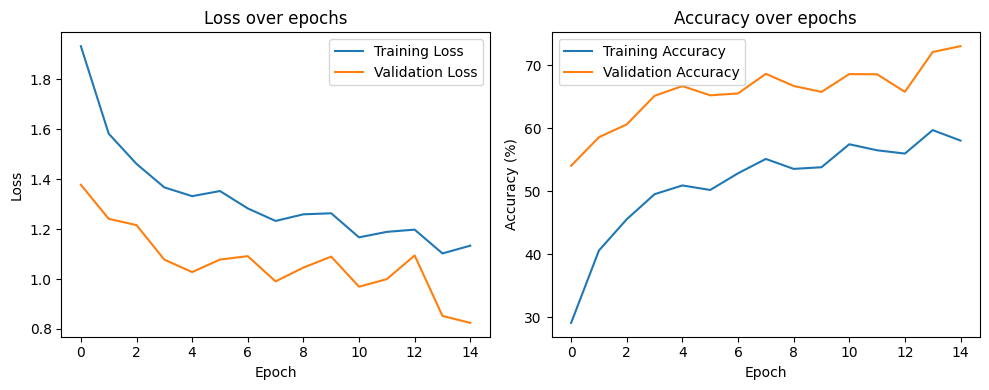

In [30]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

### Adversarial Attack FGSM : Fast Gradient Sign Method :))))))


In [31]:
def FGSM(model, x, y, eps):

        x_ = Variable(x.data, requires_grad=True)
        h_ = model(x_)
        criterion= torch.nn.CrossEntropyLoss()
        cost = criterion(h_, y)
        model.zero_grad()
        cost.backward()

        #perturbation
        pert= eps*x_.grad.detach().sign()

        x_adv = x_ + pert

        h_adv = model(x_adv)
        _,y_adv=torch.max(h_adv.data,1)
        return x_adv, h_adv, y_adv, pert

### and Noise Functions

In [32]:
def perturb_image(image, num_pixels=15):

    perturbed_image = image.clone()

    for _ in range(num_pixels):
        x = random.randint(0, image.size(2) - 1)
        y = random.randint(0, image.size(3) - 1)
        perturbed_image[:, :, x, y] = torch.rand_like(perturbed_image[:, :, x, y])

    return perturbed_image

### Now generate these Adversarial

In [33]:
def create_adversarial_dataset(model, test_loader, epsilon):
    adversarial_examples = []
    original_labels = []
    adversarial_labels = []

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        perturbed_inputs = perturb_image(inputs)

        adv_inputs, _, adv_labels, _ = FGSM(model, perturbed_inputs, labels, epsilon)

        adversarial_examples.append(adv_inputs)
        original_labels.append(labels)
        adversarial_labels.append(adv_labels)

    adversarial_examples = torch.cat(adversarial_examples, dim=0).to(device)
    original_labels = torch.cat(original_labels, dim=0).to(device)
    adversarial_labels = torch.cat(adversarial_labels, dim=0).to(device)

    return adversarial_examples, original_labels, adversarial_labels

### evaluation

In [34]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    return 100 * correct / total

### calling generation of adv

In [35]:
epsilon = 0.1
num_pixels = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Create a TensorDataset and DataLoader for adversarial examples


In [37]:
adversarial_test, original_labels_test, adversarial_labels_test = create_adversarial_dataset(model, test_loader, epsilon)
adv_test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(adversarial_test, original_labels_test), batch_size=100, shuffle=True)

print("Adversarial dataset created and saved successfully!")

Adversarial dataset created and saved successfully!


In [38]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [40]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified


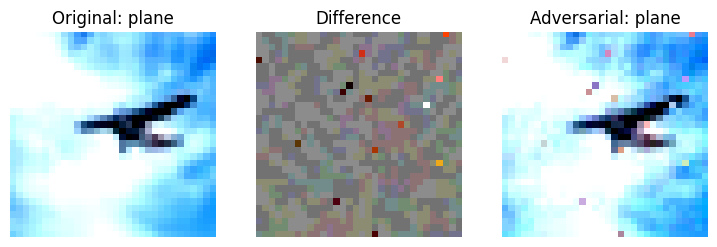

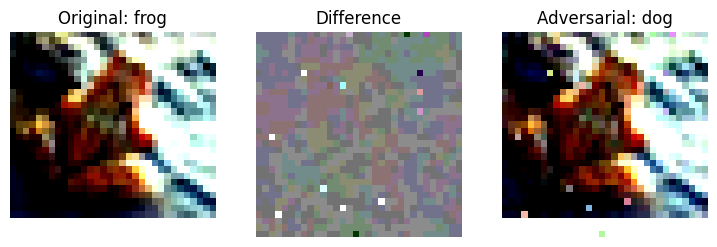

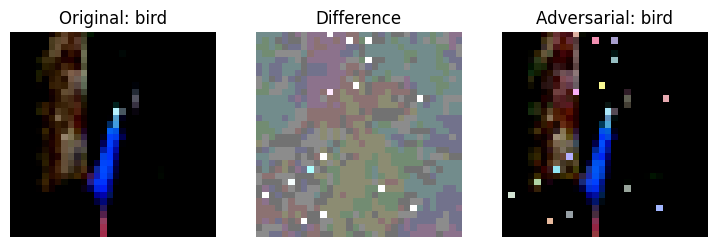

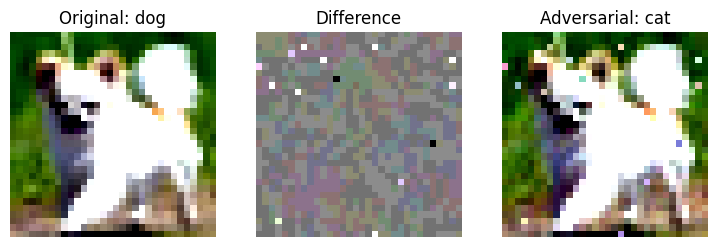

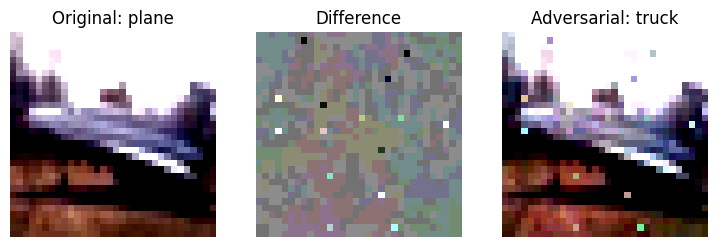

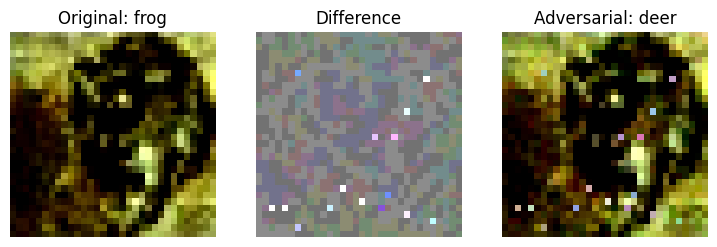

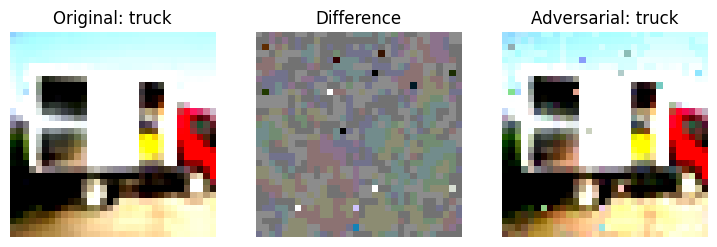

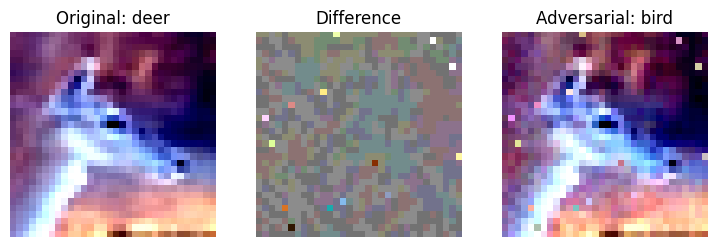

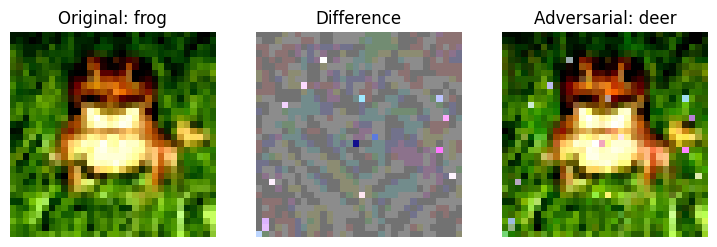

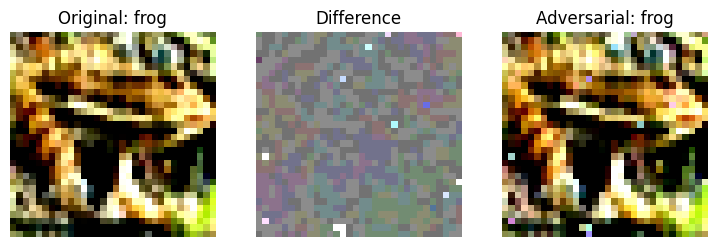

In [42]:
def imshow(img, title=None, subplot=None):
    img = img.detach().cpu() / 2 + 0.5 
    npimg = img.numpy()
    ax = plt.subplot(1, 3, subplot)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    if title:
        plt.title(title)

num_images = len(adversarial_test)
selected_indices = random.sample(range(num_images), 10)

for idx in selected_indices:
    plt.figure(figsize=(9, 3))  

    original_image = testset[idx][0].to(adversarial_test.device)  
    original_label = original_labels_test[idx].item()
    adversarial_image = adversarial_test[idx]
    adversarial_label = adversarial_labels_test[idx].item()

    difference = adversarial_image - original_image

    imshow(original_image, title=f'Original: {classes[original_label]}', subplot=1)

    imshow(difference, title='Difference', subplot=2)

    imshow(adversarial_image, title=f'Adversarial: {classes[adversarial_label]}', subplot=3)

    plt.show()

### original test accuracy

In [43]:
original_accuracy = evaluate_model(model, test_loader)
print(f"Accuracy on the original test set: {original_accuracy:.2f}%")

Accuracy on the original test set: 74.60%


### adversarial accuracy

In [46]:
adversarial_accuracy = evaluate_model(model, adv_test_loader)
print(f"Accuracy on the adversarial and noisy test set: {adversarial_accuracy:.2f}%")

Accuracy on the adversarial and noisy test set: 37.22%


### define FeatureExtractor

In [47]:
class FeatureExtractor(nn.Module):
    def __init__(self, model):
        super(FeatureExtractor, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return x

### Initialize feature extractor


In [48]:
feature_extractor = FeatureExtractor(model).to(device)

### now define extract features function

In [49]:
def extract_features(data_loader, model):
    model.eval()
    features = []
    targets = []
    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            feature = model(data)
            features.append(feature.cpu().numpy())
            targets.append(target.cpu().numpy())

    features = np.concatenate(features)
    targets = np.concatenate(targets)
    return features, targets

### feature extraction from original test set and reduction for using UMAP

In [50]:
original_features, original_labels = extract_features(test_loader, feature_extractor)
umap_reducer_original = UMAP(n_neighbors=5, n_components=2, metric='euclidean', random_state=42)
umap_embedding_original = umap_reducer_original.fit_transform(original_features)

/opt/conda/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


### KNN_Classifier - Prediction on the same embeddings - train on original embeddings

In [51]:
knn_original = KNeighborsClassifier(n_neighbors=5)
knn_original.fit(umap_embedding_original, original_labels)
y_pred_original = knn_original.predict(umap_embedding_original)

### feature extraction from adversarial test set and reduction for using UMAP

In [54]:
adversarial_features, adversarial_label = extract_features(adv_test_loader, feature_extractor)
umap_reducer_adversarial = UMAP(n_neighbors=5, n_components=2, metric='euclidean')
umap_embedding_adversarial = umap_reducer_adversarial.fit_transform(adversarial_features)

### KNN Classification on adversarial embeddings

In [55]:
knn_adversarial = KNeighborsClassifier(n_neighbors=5)
knn_adversarial.fit(umap_embedding_adversarial, adversarial_label)
y_pred_adversarial = knn_adversarial.predict(umap_embedding_adversarial)


### Plotting UMAP embeddings for the original dataset

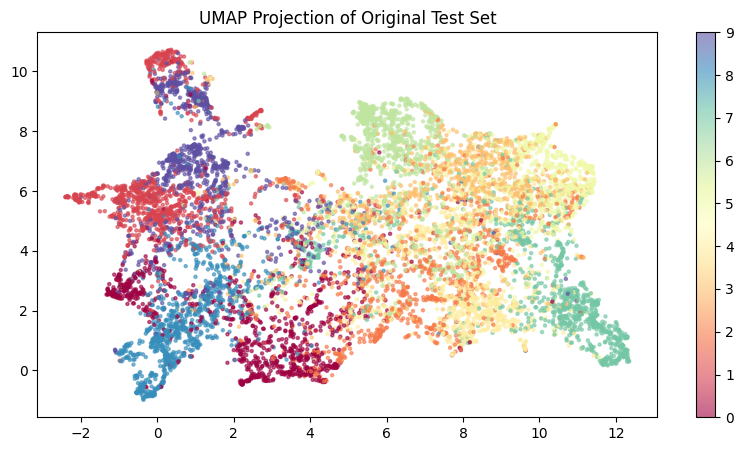

In [57]:
plt.figure(figsize=(10, 5))
plt.scatter(umap_embedding_original[:, 0], umap_embedding_original[:, 1], c=original_labels, cmap='Spectral', s=5, alpha=0.6)
plt.title('UMAP Projection of Original Test Set')
plt.colorbar()
plt.show()

### Calculate and print accuracy on original embeddings

In [58]:
accuracy_original = accuracy_score(original_labels, y_pred_original)
print(f"KNN Classification Accuracy on Original Test Set Embeddings: {accuracy_original:.2f}")

KNN Classification Accuracy on Original Test Set Embeddings: 0.75


### Plotting UMAP embeddings for the adversarial dataset

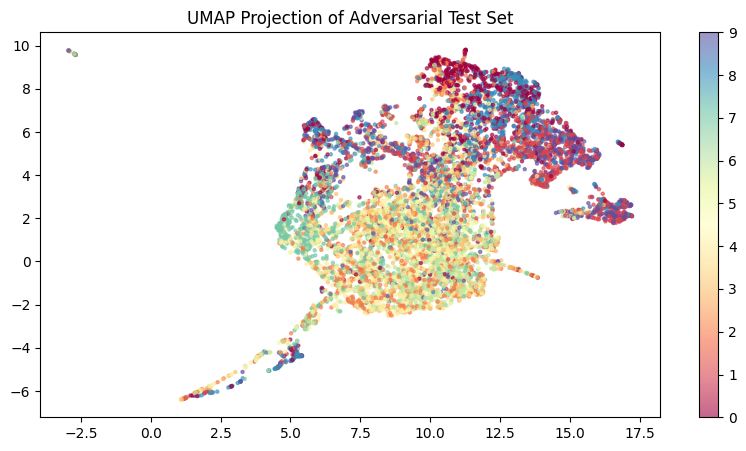

In [59]:
plt.figure(figsize=(10, 5))
plt.scatter(umap_embedding_adversarial[:, 0], umap_embedding_adversarial[:, 1], c=adversarial_label, cmap='Spectral', s=5, alpha=0.6)
plt.title('UMAP Projection of Adversarial Test Set')
plt.colorbar()
plt.show()

### Calculate and print accuracy on adversarial embeddings


In [60]:
accuracy_adversarial = accuracy_score(adversarial_label, y_pred_adversarial)
print(f"KNN Classification Accuracy on Adversarial Test Set Embeddings: {accuracy_adversarial:.2f}")

KNN Classification Accuracy on Adversarial Test Set Embeddings: 0.51
